In [20]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10, num_negative_samples=1,
                 sparse=True).to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)

Epoch: 01, Loss: 8.0358, Acc: 0.1640
Epoch: 02, Loss: 6.0054, Acc: 0.1870
Epoch: 03, Loss: 4.9059, Acc: 0.2230
Epoch: 04, Loss: 4.0887, Acc: 0.2420
Epoch: 05, Loss: 3.4419, Acc: 0.2830
Epoch: 06, Loss: 2.9353, Acc: 0.3280
Epoch: 07, Loss: 2.5234, Acc: 0.3640
Epoch: 08, Loss: 2.1967, Acc: 0.3900
Epoch: 09, Loss: 1.9373, Acc: 0.4230
Epoch: 10, Loss: 1.7247, Acc: 0.4530
Epoch: 11, Loss: 1.5552, Acc: 0.4700
Epoch: 12, Loss: 1.4206, Acc: 0.4910
Epoch: 13, Loss: 1.3112, Acc: 0.5160
Epoch: 14, Loss: 1.2245, Acc: 0.5430
Epoch: 15, Loss: 1.1550, Acc: 0.5700
Epoch: 16, Loss: 1.0988, Acc: 0.5950
Epoch: 17, Loss: 1.0555, Acc: 0.6120
Epoch: 18, Loss: 1.0201, Acc: 0.6250
Epoch: 19, Loss: 0.9926, Acc: 0.6320


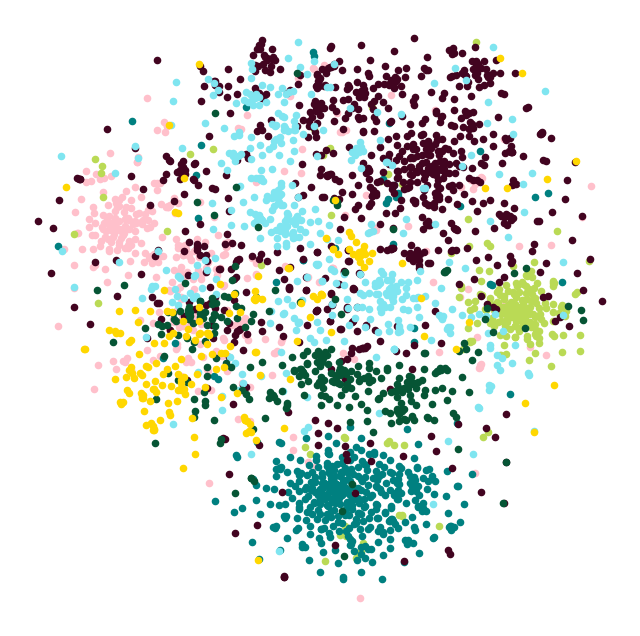

In [3]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask], max_iter=150)
    return acc


for epoch in range(1, 20):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700']
plot_points(colors)


In [7]:
len(model(torch.tensor([0,], device=device))[0])

128

In [ ]:
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

In [2]:
data.to_dict()

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'edge_index': tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
 'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]),
 'val_mask': tensor([False, False, False,  ..., False, False, False]),
 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])}

In [8]:
sum(data.val_mask)

tensor(500)

In [9]:
sum(data.train_mask)

tensor(140)

In [10]:
sum(data.test_mask)

tensor(1000)

In [16]:
data.to_dict()

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'edge_index': tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
 'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]),
 'val_mask': tensor([False, False, False,  ..., False, False, False]),
 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])}

In [15]:
from torch_geometric.data import Data

test_dict = Data()

In [17]:
test_dict.from_dict({
    "x": [[0, 0, 1], [1, 0, 0], [0, 1, 0]],
    "y": [0, 1, 2],
})

Data(x=[3], y=[3])

In [18]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [20]:
data.x[0]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [21]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [22]:
data.num_edges

10556

In [9]:
model.eval()
z = model()

tensor([-0.5465,  0.0076,  0.1382,  0.6754,  0.4807, -0.4341,  0.5086, -0.0320,
         0.0275, -0.5144,  0.3495, -0.0478,  0.0836,  0.1169, -0.4879, -0.4622,
        -0.4631,  0.6280,  0.4209,  0.1545, -0.3348, -0.0535, -0.2694, -1.2276,
         0.2043, -0.0372,  0.1923,  0.0544,  0.3347,  0.3523,  0.0587, -0.6535,
         0.0084,  0.1411, -0.3219, -0.1359, -0.4161, -0.0782, -0.3791,  0.1811,
        -0.5716, -0.1574,  0.1747, -0.0918, -0.1611,  0.1367, -0.1651,  0.7901,
        -0.2700, -0.2394, -0.3403, -0.4547,  0.0420,  0.3751, -0.0216, -0.2776,
         0.9097, -0.1419, -0.1955, -0.5830,  0.0189,  0.1514,  0.5541, -0.0588,
         0.1488,  0.3141, -0.3390,  0.0066, -0.0992, -0.0841,  0.8287, -0.0950,
        -0.5239,  0.3206,  0.5723, -0.1939,  0.6698, -0.0336,  0.6757,  0.2166,
        -0.2598,  0.3123,  0.0812,  0.0782,  0.6149,  0.5289, -0.0713, -0.8755,
        -0.5224, -0.4033, -0.5902,  0.5754,  0.2130, -0.0913, -0.1384, -0.5095,
        -0.1072,  0.2243, -0.4903,  0.10